# Neural Machine Translation

General Reference: https://github.com/nyu-dl/NLP_DL_Lecture_Note/blob/master/lecture_note.pdf <br>
Original Notebook: https://github.com/nyu-dl/AMMI-2019-NLP-Part2

### Install packages

In [ ]:
!pip install torch
!pip install subword-nmt
!pip install sacremoses
!pip install googletrans==3.1.0a0
!pip install pandas
!pip install sacrebleu
!pip install matplotlib
!pip install requests
!pip install bertviz

### Python imports

In [6]:
"""
To run this notebook in Google Colab, you need to the following first:
1. Go to "Runtime / Change runtime type", then select "GPU" in the "Hardware accelerator" drop-down list
2. Open this link: https://drive.google.com/drive/folders/1E07YaKths98YpoBCH2PjdtTPqOXgfdZB?usp=sharing
3. Then go to "Shared with me" in your Google Drive, right-click the "ALPS2022-NMT" folder
and select "Add shortcut to Drive"

Optionally, if you don't have a Google Drive account, you can set colab to False,
and the data and models will be downloaded in Colab (might take longer).
"""

cpu = False
colab = True   # set to False to run locally and not from Google Colab
model_root = 'models'  # where new models will be saved

if colab:
    # Download the python files from the ALPS Github
    !wget https://raw.githubusercontent.com/naverlabseurope/ALPS2021-MT-LAB/ALPS2022/data.py
    !wget https://raw.githubusercontent.com/naverlabseurope/ALPS2021-MT-LAB/ALPS2022/models.py
    # Mount your Google Drive, which should contain a link to "ALPS2022-NMT"
    from google.colab import drive
    drive.flush_and_unmount()
    drive.mount('/content/drive')
    root_dir = '/content/drive/MyDrive/ALPS2022-NMT'
    # model_root = '/content/drive/MyDrive/ALPS2022-models' # uncomment to save your models to your Google Drive
    !ls {root_dir}/*
else:
    # Download the datasets and pre-trained models
    # Modify this script to download data in other language pairs than EN-FR
    !scripts/download-data.sh
    root_dir = '.'

import os
import sys
import re
import data
import models
import pandas
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from collections import OrderedDict
from tqdm.notebook import tqdm
from subword_nmt.apply_bpe import BPE   # segment text into subword units
from data import load_dataset, binarize, load_or_create_dictionary, BatchIterator
%matplotlib inline

# Set up Google Translate API for Comparison
from googletrans import Translator   # https://github.com/ssut/py-googletrans
google_translator = Translator()

## The dataset

We will work with a small English to French dataset from https://www.manythings.org/anki/. It contains translations of short and simple sentences aimed at foreign language learners (from the [Tatoeba collaborative database](https://tatoeba.org/en/)). Of course, models trained on this data will not perform well on longer, more sophisticated sentences. They also won't be very robust to domain shift and input noise. To train stronger models, some larger datasets can be downloaded from https://www.statmt.org/wmt21/ or https://opus.nlpl.eu/.

In [7]:
source_lang, target_lang = 'en', 'fr'

# paths to the datasets and pretrained models
data_dir = os.path.join(root_dir, 'data')
pretrained_model_dir = os.path.join(root_dir, 'pretrained_models', f'{source_lang}-{target_lang}')

# path to the newly trained models
model_dir = os.path.join(model_root, f'{source_lang}-{target_lang}')

!mkdir -p {model_dir}
!head -5 {data_dir}/train.en-fr.en

is it cancer ?
it took half an hour .
how many caps do you own ?
you should read many books when you are young .
he is a student at harvard .


## Load and preprocess the data

1. Load the BPE model
2. Load the parallel corpora for this language pair (train, valid and test). `load_dataset` will load a corpus and tokenize it with the BPE model with the given `preprocess` function.
3. Create (or load) dictionaries that map BPE tokens to token IDs (`load_or_create_dictionary` function)
4. Binarize the data: map source and target text sequences to sequences of IDs, and sort the training set by length (`binarize` function)
5. Create batches (`BatchIterator` class): group multiple sequence pairs of similar length together, pad them to the maximum length and create numpy arrays that can be used to train or evaluate our models

In [8]:
# set the random seed: initialize the random number generator for reproducibility
def reset_seed(seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)

### 1. Load the BPE model (multilingual BPE model, works with French, German and English)

In [9]:
train_path = os.path.join(data_dir, f'train.{source_lang}-{target_lang}')
valid_path = os.path.join(data_dir, f'valid.{source_lang}-{target_lang}')
test_path = os.path.join(data_dir, f'test.{source_lang}-{target_lang}')
bpe_path = os.path.join(data_dir, 'bpecodes.de-en-fr')

with open(bpe_path) as bpe_codes:
    bpe_model = BPE(bpe_codes)

def preprocess(source_line, target_line=None, source_lang=None, target_lang=None):
    # BPE segmentation: e.g., 'He overslept this morning .' -> he over@@ slept this morning .'
    # modify this function to tweak the pre-processing (e.g., to add control tags / language codes)
    source_line = bpe_model.segment(source_line.lower())
    if target_line is not None:
        target_line = bpe_model.segment(target_line.lower())
    return source_line, target_line

def postprocess(line):
    # Merge BPE-tokenized sequences back into sequences of words:
    # "ce matin , il s' est réve@@ illé trop tard ." -> "ce matin , il s' est réveillé trop tard ."
    return line.replace('@@ ', '')

### 2. Load and preprocess the parallel corpora

In [10]:
train_data = load_dataset(train_path, source_lang, target_lang, preprocess, max_size=None)  # pandas.DataFrame
# set max_size to 10000 for fast debugging
valid_data = load_dataset(valid_path, source_lang, target_lang, preprocess)
test_data = load_dataset(test_path, source_lang, target_lang, preprocess)
print(train_data[:5])   # to see the first 5 rows of train_data

                                       source_data  \
0                                   is it cancer ?   
1                           it took half an hour .   
2                       how many caps do you own ?   
3  you should read many books when you are young .   
4                     he is a student at harvard .   

                                         target_data  \
0                          s' agit-il d' un cancer ?   
1                         ça a pris une demi-heure .   
2                combien de casquettes possèdes-tu ?   
3  on devrait lire beaucoup de livres quand on es...   
4                        il est étudiant à harvard .   

                                    source_tokenized  \
0                                [is, it, cancer, ?]   
1                      [it, took, half, an, hour, .]   
2             [how, many, cap@@, s, do, you, own, ?]   
3  [you, should, read, many, books, when, you, ar...   
4           [he, is, a, student, at, harv@@, ard, .]   

 

### 3. Load or create the dictionaries

In [11]:
source_dict_path = os.path.join(pretrained_model_dir, f'dict.{source_lang}.txt')
target_dict_path = os.path.join(pretrained_model_dir, f'dict.{target_lang}.txt')

source_dict = load_or_create_dictionary(
    source_dict_path,
    train_data['source_tokenized'],
    reset=False,    # set reset to True if you're changing the data or the preprocessing
)
print(source_dict.words[:100])   # print the first 100 words in the source vocabulary

target_dict = load_or_create_dictionary(
    target_dict_path,
    train_data['target_tokenized'],
    reset=False,
)
print(target_dict.words[:100])

print('source vocab size:', len(source_dict))
print('target vocab size:', len(target_dict))

['<sos>', '<eos>', '<unk>', '<pad>', '.', 'the', '?', 'is', 'i', 'to', 'he', 'you', 'tom', ',', 'it', 'a', "'t", 'of', '"', 'do', 'was', "'s", 'this', 'are', 'in', 'we', 'have', 'can', 'what', 'that', 'me', 'she', 'y', 'don', 'his', 'and', 'my', 'will', 'an', 'at', 'him', 'from', 'your', 'how', 'for', 'with', 'go', 'did', 'day', 'not', 'want', 'on', 'time', "'m", 'they', 'be', '!', 'one', 'about', 'her', 'know', 'where', 'when', 'like', 'today', 'has', 'good', 'as', 'very', 'ing', 'there', 'just', 'all', 'no', 'work', "'re", "'ll", 'ed', 'ts', 'up', 'make', 'had', 'out', 'by', 'people', 'more', 'mary', 'think', 'am', 'see', 'or', 'really', 'here', 'any', 'get', "'ve", 'why', 'who', 'so', 'let']
['<sos>', '<eos>', '<unk>', '<pad>', '.', 'est', 'de', ',', '?', 'il', 'le', 'les', 'tom', 'la', 'je', 'a', 'pas', 'à', 'ai', 'en', 'ne', "j'", "d'", 'que', 'un', "n'", "l'", 'une', 'vous', 'ce', 'nous', 'faire', "s'", 'du', 'me', 'tu', 'des', '"', "qu'", 'se', 'et', "c'", 'plus', 'sont', 'était

### 3. Use the dictionaries to map tokens to indices. The training set is also sorted by length for more efficient batching.

In [12]:
binarize(train_data, source_dict, target_dict, sort=True)
binarize(valid_data, source_dict, target_dict, sort=False)
binarize(test_data, source_dict, target_dict, sort=False)
print(train_data[:5])  # print the first 5 rows of train_data
# The 'source_bin' and 'target_bin' columns contain the sequences of indices
# Indices of 1 correspond to the EOS token

        source_data      target_data  source_tokenized    target_tokenized  \
354        enough !          assez !       [enough, !]          [assez, !]   
1105      finally !          enfin !      [finally, !]          [enfin, !]   
4365         fire !            feu !         [fire, !]            [feu, !]   
7206  immediately !  immédiatement !  [immediately, !]  [immédiatement, !]   
9258         sing !         chante !         [sing, !]         [chante, !]   

         source_bin  source_len     target_bin  target_len  
354    [254, 56, 1]           3   [291, 47, 1]           3  
1105  [1042, 56, 1]           3  [2237, 47, 1]           3  
4365   [545, 56, 1]           3   [771, 47, 1]           3  
7206  [1535, 56, 1]           3  [1426, 47, 1]           3  
9258   [689, 56, 1]           3  [1108, 47, 1]           3  


### Data statistics:

In [13]:
print('train_size={}, valid_size={}, test_size={}, min_len={}, max_len={}, avg_len={:.1f}'.format(
    len(train_data),
    len(valid_data),
    len(test_data),
    train_data['source_len'].min(),
    train_data['source_len'].max(),
    train_data['source_len'].mean(),
))

print('Train source length distribution:')
# The 90th percentile indicates the point where 90% percent of the data have values lower than this number.
# We see that 90% of training examples have 14 source words or less
# and 99% of all training examples have 27 source words or less.
print(train_data['source_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999]))

train_size=82297, valid_size=2000, test_size=2000, min_len=3, max_len=297, avg_len=9.9
Train source length distribution:
0.5000      9.0000
0.7500     11.0000
0.9000     14.0000
0.9500     17.0000
0.9900     27.0000
0.9990     57.0000
0.9999    105.0816
Name: source_len, dtype: float64


### 5. Build batches. The training batches are automatically shuffled before each epoch

In [14]:
max_len = 30       # maximum 30 tokens per sentence (longer sequences will be truncated)
batch_size = 512   # maximum 512 tokens per batch (decrease if you get OOM errors, increase to speed up training)

reset_seed()

train_iterator = BatchIterator(train_data, source_lang, target_lang, batch_size, max_len, shuffle=True)
valid_iterator = BatchIterator(valid_data, source_lang, target_lang, batch_size, max_len, shuffle=False)
test_iterator = BatchIterator(test_data, source_lang, target_lang, batch_size, max_len, shuffle=False)

print('Example of training batch:')
print(next(iter(train_iterator)))

Example of training batch:
{'source': tensor([[  31,   20,  398,  366,  178,    4,    1],
        [  10,    7, 1299,   34,  102,    4,    1],
        [  10,    7,   15,   66, 1382,    4,    1],
        [  23,   11,  325,   44,  600,    6,    1],
        [   8,   53,   49, 2086,  227,    4,    1],
        [  12, 1059,  195,   30,  191,    4,    1],
        [  31,  673, 2234,    5,  102,    4,    1],
        [  31,   21,  364,  323,  200,    4,    1],
        [  27,   11, 1396,   42,  674,    6,    1],
        [  12,    7,   15,   66,  328,    4,    1],
        [ 213, 2341, 1531,   51,   11,    4,    1],
        [  43,   47,   11,  674,   12,    6,    1],
        [  25,   75,   49,  266,  340,    4,    1],
        [   5,  388,   27,  394,  601,    4,    1],
        [ 213,    8,  527,   45,   11,    6,    1],
        [  12,  223,   16,  107,   30,    4,    1],
        [ 186,   24, 1628,   45,   30,    4,    1],
        [  43,  203,    7,   22,  531,    6,    1],
        [   8,   33,   16,

# Sequence to sequence models

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder-Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of usually two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence. Essentially, all we need is some mechanism to read the source sentence and create an encoding and some mechanism to read the encoding and decode it to the target language. 

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "I am not the
black cat" → "Je ne suis pas le chat noir". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the meaning of the input sequence into a single
vector — a single point in some N dimensional space of sentences.


## The Encoder

The encoder is anything which takes in a sentence and gives us a representation for the sentence. 

The encoder of a seq2seq network can be a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

However, we will start with a simpler Bag-of-Words encoder and then move on to more complex encoders.

### Bag-of-Words encoder

In [15]:
bow_encoder = models.BOW_Encoder(
    source_dict=source_dict,
    hidden_size=512,
    num_layers=1,
    dropout=0.1,
    reduce='sum',
)

In [16]:
print(bow_encoder)

BOW_Encoder(
  (embedding): Embedding(3302, 512, padding_idx=3)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
  )
)


## The decoder

The decoder is another network that takes the encoder's output vector(s) and outputs a sequence of words to create the translation.

### Decoder without attention

In the simplest seq2seq decoder we use only the last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence.

At every step of decoding, the decoder is given an input token and the encoder's context vector and it updates its internal state, which is then used to predict the next word. The initial input token is the start-of-sequence <SOS> token. The next inputs are the decoder's own predictions (at test time) or the ground-truth tokens (at train time).

In [17]:
bow_decoder = models.RNN_Decoder(
    target_dict=target_dict,
    hidden_size=512,
    num_layers=1,
    dropout=0.1,
)

In [18]:
print(bow_decoder)

RNN_Decoder(
  (embedding): Embedding(3674, 512, padding_idx=3)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (gru): GRU(1024, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=3674, bias=True)
  (softmax): LogSoftmax(dim=2)
)


In [19]:
bow_model = models.EncoderDecoder(
    bow_encoder,
    bow_decoder,
    lr=0.001,
    use_cuda=not cpu,
)

### Training code

In [20]:
def evaluate_model(model, *test_or_valid_iterators, record=False):
    """
    Evaluate given models with given test or validation sets. This will compute both chrF and validation loss.
    
    model: instance of models.EncoderDecoder
    test_or_valid_iterators: list of BatchIterator
    record: save scores in the model checkpoint
    """
    scores = []
    
    # Compute chrF and valid loss over all test or validation sets
    for iterator in test_or_valid_iterators:
        src, tgt = iterator.source_lang, iterator.target_lang
        loss = 0
        for batch in iterator:
            loss += model.eval_step(batch) / len(iterator)
        translation_output = model.translate(iterator, postprocess)
        score = translation_output.score

        print(f'{src}-{tgt}: loss={loss:.2f}, chrF={score:.2f}')

        if record:  # store the metrics in the model checkpoint
            model.record(f'{src}_{tgt}_loss', loss)
            model.record(f'{src}_{tgt}_chrf', score)
        
        scores.append(score)

    # Average the validation chrF scores
    score = sum(scores) / len(scores)
    if len(scores) > 1:
        print(f'chrF={score:.2f}')

    return score


def train_model(model, train_iterator, valid_iterators, checkpoint_path, epochs=10):
    """
    Train given model for given number of epochs.
    The best performing checkpoint (according to average chrF on "valid_iterators") will be saved
    under 'checkpoint_path'.
    
    By default, the optimizer, epoch counter and learning rate scheduler are not reset.
    This means that this function can be called several times:
        train_model(epochs=2) is equivalent to train_model(epochs=1); train_model(epochs=1)
    
    model: instance of models.EncoderDecoder
    train_iterator: instance of data.BatchIterator used for generating training batches
    valid_iterators: list of BatchIterator used for evaluation
    checkpoint_path: path where the model will be saved
    epochs: iterate this many times over train_iterator
    """
    epochs += model.epoch

    reset_seed()

    best_score = -1
    for epoch in range(model.epoch + 1, epochs + 1):

        start = time.time()
        running_loss = 0

        print(f'Epoch [{epoch}/{epochs}]')

        # Iterate over training batches for one epoch
        with tqdm(enumerate(train_iterator), total=len(train_iterator)) as t:

            for i, batch in t:
                running_loss += model.train_step(batch)
                t.postfix = f' loss={running_loss / (i + 1):.3f}'

        # Average training loss for this epoch
        epoch_loss = running_loss / len(train_iterator)

        print(f'loss={epoch_loss:.3f}, time={time.time() - start:.2f}')
        model.record('train_loss', epoch_loss)

        score = evaluate_model(model, *valid_iterators, record=True)

        # Update the model's learning rate based on current performance.
        # This scheduler divides the learning rate by 10 if chrF does not improve.
        model.scheduler_step(score)

        # Save a model checkpoint if it has the best validation chrF so far
        if score > best_score:
            best_score = score
            model.save(checkpoint_path)

        print('=' * 50)

    print(f'Training completed. Best chrF is {best_score:.2f}')


def plot_loss(model):
    """
    Plot the training vs validation loss/chrf for the given model,
    provided those metrics are stored in the checkpoint.
    """
    metrics = model.metrics
    epochs = sorted(metrics.keys())
    train_loss = [metrics[epoch]['train_loss'] for epoch in epochs]
    valid_loss = [
        mean(v for k, v in metrics[epoch].items() if 'loss' in k and k != 'train_loss')
        for epoch in epochs
    ]
    chrf = [
        mean(v for k, v in metrics[epoch].items() if 'chrf' in k)
        for epoch in epochs
    ]
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(epochs, train_loss, linestyle='solid', label='Train loss')
    ax1.plot(epochs, valid_loss, linestyle='dashdot', label='Valid loss')
    ax2.plot(epochs, chrf, 'g--', label='Valid chrF')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('chrF')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

### Train a model with BOW encoder and RNN decoder (or load a pre-trained model)

checkpoint path: ./pretrained_models/en-fr/bow.pt


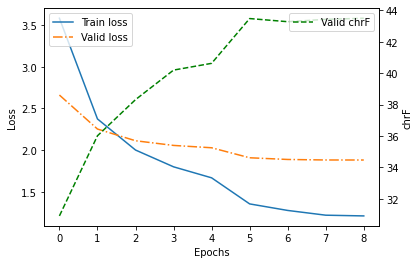

In [21]:
# Set this value to True to train your own model. By default, a pre-trained model will be loaded.
# Tip: you can set "epochs" to a small value (e.g., 2) and re-run this cell several times to continue training you model (`train_model` does not reset the model)
# Note that you can load the pre-trained model, then re-run this cell with train_again=False to continue training it
train_again = False

if train_again:
    checkpoint_path = os.path.join(model_dir, 'bow.pt')
else:
    checkpoint_path = os.path.join(pretrained_model_dir, 'bow.pt')

print('checkpoint path:', checkpoint_path)

if os.path.exists(checkpoint_path) and not train_again:
    bow_model.load(checkpoint_path)   # trained for 10 epochs
else:
    train_model(bow_model, train_iterator, [valid_iterator],
                epochs=2,
                checkpoint_path=checkpoint_path)

plot_loss(bow_model)

### Compute chrF on the test set

In [22]:
chrf = evaluate_model(bow_model, test_iterator)

en-fr: loss=2.14, chrF=41.13


### Interact with the model

In [23]:
def show_attention(input, output, attention_weights):
    """
    Plot an encoder-decoder attention matrix
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.colorbar(ax.matshow(attention_weights, cmap='bone', aspect='auto'))
    xlabels = input.split() + [data.EOS_TOKEN]
    ylabels = output.split() + [data.EOS_TOKEN]
    ax.set_xticks(range(len(xlabels)))
    ax.set_xticklabels(xlabels, rotation=90)
    ax.set_yticks(range(len(ylabels)))
    ax.set_yticklabels(ylabels)
    plt.show()


def encode_as_batch(sentence, dictionary):
    """
    Create a batch from a single sentence
    """
    sentence = f'{sentence} {data.EOS_TOKEN}'
    tensor = dictionary.txt2vec(sentence).unsqueeze(0)
    return {
        'source': tensor,
        'source_len': torch.tensor(tensor.shape[-1:]),
    }


def translate(model, sentence, preprocess=preprocess, source_lang=source_lang, target_lang=target_lang,
              return_output=False):
    """
    Translate given sentence with given model. Also show translation outputs by Google Translate for comparison.

    sentence (str): sentence to translate
    preprocess: function used to tokenize the input sentence
    source_lang (str): source language code (used for Google Translate and as a parameter to "preprocess")
    target_lang (str): target language code (used for Google Translate and as a parameter to "preprocess")
    return_output: if True, returns the translation and attention matrices. If False, just prints the translations.
    """
    sentence_tok, _ = preprocess(sentence, target_line=None, source_lang=source_lang, target_lang=target_lang)
    print('Tokenized source:', sentence_tok)
    batch = encode_as_batch(sentence_tok, model.source_dict)
    prediction, attn_matrix, enc_self_attn = model.decoding_step(batch)
    prediction = prediction[0]
    prediction_detok = postprocess(prediction)
    print('Prediction:', prediction)
    print('Detokenized prediction:', prediction_detok)

    print('Google Translate ({}->{}): {}'.format(
        source_lang,
        target_lang,
        google_translator.translate(sentence, src=source_lang, dest=target_lang).text,
    ))
    print('Google Translate on prediction ({}->{}): {}'.format(
        target_lang,
        source_lang,
        google_translator.translate(prediction_detok, src=target_lang, dest=source_lang).text,
    ))

    results = {
        'source_tokens': sentence_tok.split() + ['<eos>'],
        'prediction_detok': prediction_detok,
        'prediction_tokens': prediction.split(),
    }

    if attn_matrix is not None:
        attn_matrix = attn_matrix[0].detach().cpu().numpy()
        results['attention_matrix'] = attn_matrix
        show_attention(sentence_tok, prediction, attn_matrix)
    
    if enc_self_attn is not None:
        results['encoder_self_attention_list'] = enc_self_attn
    
    if return_output:
        return results

In [24]:
# Translate some English sentence with the model
translate(bow_model, 'hello how are you ?')
# The Google Translate outputs are shown for reference to non-French speakers:
# - The en->fr output is a high-quality translation of the input sentence
# - The fr->en output is a translation back into English of our model's French translation (so that you can assess its quality)

Tokenized source: hello how are you ?
Prediction: sal@@ ut , comment vas-tu ?
Detokenized prediction: salut , comment vas-tu ?
Google Translate (en->fr): Bonjour comment vas-tu ?
Google Translate on prediction (fr->en): Hi, how are you ?


The biggest limitation of a Bag-of-Words encoder is that it is insensitive to word order: <br>
when shuffling the words in the previous sentence, you get the same output.

In [25]:
translate(bow_model, 'you are hello ? how')

Tokenized source: you are hello ? how
Prediction: sal@@ ut , comment vas-tu ?
Detokenized prediction: salut , comment vas-tu ?
Google Translate (en->fr): tu es bonjour ? comment
Google Translate on prediction (fr->en): Hi, how are you ?


In [26]:
translate(bow_model, "she 's five years older than me .")

Tokenized source: she 's five years older than me .
Prediction: elle a plus de cinq ans que moi .
Detokenized prediction: elle a plus de cinq ans que moi .
Google Translate (en->fr): elle a cinq ans de plus que moi .
Google Translate on prediction (fr->en): she is more than five years old than me.


## RNN encoder + RNN decoder

Now let's look at a more powerful model, which also uses an RNN for encoding the source sequence. Contrary to the Bag-of-Words encoder, it is sensitive to word order.

In [27]:
rnn_encoder = models.RNN_Encoder(
    source_dict=source_dict,
    hidden_size=512,
    num_layers=1,
    dropout=0.1,
)

In [28]:
print(rnn_encoder)

RNN_Encoder(
  (embedding): Embedding(3302, 512, padding_idx=3)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (gru): GRU(512, 512, batch_first=True)
)


In [29]:
rnn_decoder = models.RNN_Decoder(
    target_dict=target_dict,
    hidden_size=512,
    num_layers=1,
    dropout=0.1,
)

In [30]:
print(rnn_decoder)

RNN_Decoder(
  (embedding): Embedding(3674, 512, padding_idx=3)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (gru): GRU(1024, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=3674, bias=True)
  (softmax): LogSoftmax(dim=2)
)


In [31]:
rnn_model = models.EncoderDecoder(
    rnn_encoder,
    rnn_decoder,
    lr=0.001,
    use_cuda=not cpu,
)

### Train a model with RNN encoder and RNN decoder (or load a pre-trained model)

checkpoint path: ./pretrained_models/en-fr/rnn.pt


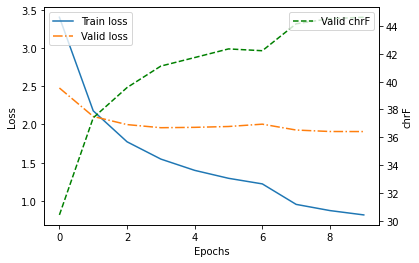

In [32]:
# Set this value to True to train your own model. By default, a pre-trained model will be loaded.
# Tip: you can set "epochs" to a small value (e.g., 2) and re-run this cell several times to continue training you model (`train_model` does not reset the model)
# Note that you can load the pre-trained model, then re-run this cell with train_again=False to continue training it
train_again = False

if train_again:
    checkpoint_path = os.path.join(model_dir, 'rnn.pt')
else:
    checkpoint_path = os.path.join(pretrained_model_dir, 'rnn.pt')

print('checkpoint path:', checkpoint_path)

if os.path.exists(checkpoint_path) and not train_again:
    rnn_model.load(checkpoint_path)   # trained for 10 epochs
else:
    train_model(rnn_model, train_iterator, [valid_iterator],
                epochs=2,
                checkpoint_path=checkpoint_path)

plot_loss(rnn_model)

### Compute chrF on the test set

In [33]:
chrf = evaluate_model(rnn_model, test_iterator)

en-fr: loss=1.87, chrF=44.40


### Interact with the model

In [34]:
translate(rnn_model, 'hello how are you ?')

Tokenized source: hello how are you ?
Prediction: sal@@ ut , comment ça va ?
Detokenized prediction: salut , comment ça va ?
Google Translate (en->fr): Bonjour comment vas-tu ?
Google Translate on prediction (fr->en): Hi how are you ?


#### Contrary to the BoW encoder, an RNN is sensitive to word ordering

In [35]:
translate(rnn_model, 'you are hello ? how')

Tokenized source: you are hello ? how
Prediction: sal@@ ut comment ?
Detokenized prediction: salut comment ?
Google Translate (en->fr): tu es bonjour ? comment
Google Translate on prediction (fr->en): Hi how ?


In [36]:
translate(rnn_model, "she 's five years older than me .")

Tokenized source: she 's five years older than me .
Prediction: elle est plus â@@ gée que moi .
Detokenized prediction: elle est plus âgée que moi .
Google Translate (en->fr): elle a cinq ans de plus que moi .
Google Translate on prediction (fr->en): she is older than me.


In [37]:
translate(rnn_model, 'i know that the last thing you want to do is help me .')

Tokenized source: i know that the last thing you want to do is help me .
Prediction: je sais que la dernière chose que je veu@@ ille faire est de faire vous aider .
Detokenized prediction: je sais que la dernière chose que je veuille faire est de faire vous aider .
Google Translate (en->fr): Je sais que la dernière chose que tu veux faire est de m'aider.
Google Translate on prediction (fr->en): I know the last thing I want to do is get help from you.


## RNN encoder + RNN decoder with encoder-decoder attention

The previous model is limited as it needs to encode the entire source sentence into a single fixed-size vector. In this exercise, this is not a big limitation as we're dealing with very short inputs, but in real world tasks you may need to encode much longer sequences (e.g., long sentences, full documents, speech inputs, images, etc.)

We will now see a similar model, but which uses an attention mechanism to look at all the encoder states, not just the last one.

In [38]:
rnn_attn_encoder = models.RNN_Encoder(
    source_dict=source_dict,
    hidden_size=512,
    num_layers=1,
    dropout=0.1,
)

In [39]:
 print(rnn_attn_encoder)

RNN_Encoder(
  (embedding): Embedding(3302, 512, padding_idx=3)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (gru): GRU(512, 512, batch_first=True)
)


In [40]:
rnn_attn_decoder = models.AttentionDecoder(
    target_dict=target_dict,
    hidden_size=512,
    num_layers=1,
    dropout=0.1,
)

In [41]:
print(rnn_attn_decoder)

AttentionDecoder(
  (embedding): Embedding(3674, 512, padding_idx=3)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (gru): GRU(1024, 512)
  (out): Linear(in_features=512, out_features=3674, bias=True)
  (attention): AttentionModule(
    (l1): Linear(in_features=512, out_features=512, bias=False)
    (l2): Linear(in_features=1024, out_features=512, bias=False)
  )
  (softmax): LogSoftmax(dim=1)
)


In [42]:
rnn_attn_model = models.EncoderDecoder(
    rnn_attn_encoder,
    rnn_attn_decoder,
    lr=0.0005,
    use_cuda=not cpu,
)

### Train a model with RNN Encoder and RNN Decoder with attention (or load a pre-trained model)

In [43]:
# Set this value to True to train your own model. By default, a pre-trained model will be loaded.
# Tip: you can set "epochs" to a small value (e.g., 2) and re-run this cell several times to continue training you model (`train_model` does not reset the model)
# Note that you can load the pre-trained model, then re-run this cell with train_again=False to continue training it
train_again = False

if train_again:
    checkpoint_path = os.path.join(model_dir, 'rnn-attn.pt')
else:
    checkpoint_path = os.path.join(pretrained_model_dir, 'rnn-attn.pt')

print('checkpoint path:', checkpoint_path)

if os.path.exists(checkpoint_path) and not train_again:
    rnn_attn_model.load(checkpoint_path)   # trained for 10 epochs
else:
    train_model(rnn_attn_model, train_iterator, [valid_iterator],
                epochs=2,
                checkpoint_path=checkpoint_path)

checkpoint path: ./pretrained_models/en-fr/rnn-attn.pt


### Compute chrF on the test set

In [44]:
chrf = evaluate_model(rnn_attn_model, test_iterator)

en-fr: loss=1.59, chrF=49.90


### Interact with the model and visualize attention matrices

Tokenized source: hello how are you ?
Prediction: bonjour ?
Detokenized prediction: bonjour ?
Google Translate (en->fr): Bonjour comment vas-tu ?
Google Translate on prediction (fr->en): Hello ?


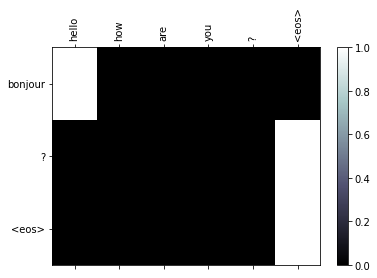

In [45]:
translate(rnn_attn_model, 'hello how are you ?')
# The heatmap below shows how much attention is given to each source position by decoder time step.
# We see for instance that when generating the word "bonjour", the decoder looks at encoder state of source word "hello"

Tokenized source: she 's five years older than me .
Prediction: elle est cinq ans plus â@@ gée que moi .
Detokenized prediction: elle est cinq ans plus âgée que moi .
Google Translate (en->fr): elle a cinq ans de plus que moi .
Google Translate on prediction (fr->en): she is five years older than me.


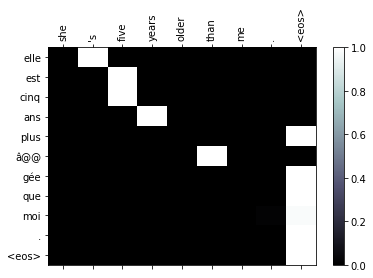

In [46]:
translate(rnn_attn_model, "she 's five years older than me .")

Tokenized source: i know that the last thing you want to do is help me .
Prediction: je sais que la dernière chose que vous vou@@ liez m' aider .
Detokenized prediction: je sais que la dernière chose que vous vouliez m' aider .
Google Translate (en->fr): Je sais que la dernière chose que tu veux faire est de m'aider.
Google Translate on prediction (fr->en): I know the last thing you wanted to help me with.


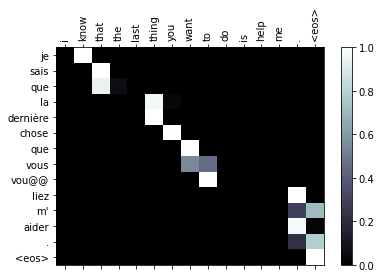

In [47]:
translate(rnn_attn_model, 'i know that the last thing you want to do is help me .')

## Transformer model

[Transformer](https://arxiv.org/abs/1706.03762) is currently the state-of-the-art for Machine Translation. The encoder uses self-attention over the previous layers. The decoder combines self-attention and encoder-decoder attention.

In [48]:
transformer_encoder = models.TransformerEncoder(
    source_dict=source_dict,
    hidden_size=512,
    num_layers=2,
    dropout=0.1,
    heads=4,
)

In [49]:
print(transformer_encoder)

TransformerEncoder(
  (embedding): Embedding(3302, 512, padding_idx=3)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (embed_positions): PositionalEncoding()
  (layers): ModuleList(
    (0): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (k_proj): Linear(in_features=512, out_features=512, bias=True)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=512, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=512, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout

In [50]:
transformer_decoder = models.TransformerDecoder(
    target_dict=target_dict,
    hidden_size=512,
    num_layers=1,
    heads=4,
    dropout=0.1,
)

In [51]:
print(transformer_decoder)

TransformerDecoder(
  (embedding): Embedding(3674, 512, padding_idx=3)
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (embed_positions): PositionalEncoding()
  (layers): ModuleList(
    (0): TransformerDecoderLayer(
      (self_attn): MultiheadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (k_proj): Linear(in_features=512, out_features=512, bias=True)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (multihead_attn): MultiheadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (k_proj): Linear(in_features=512, out_features=512, bias=True)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (line

In [52]:
transformer_model = models.EncoderDecoder(
    transformer_encoder,
    transformer_decoder,
    lr=0.0005,
    use_cuda=not cpu,
)

Note that in this notebook, we're using the same learning rate scheduler for all models:
`torch.optim.lr_scheduler.ReduceLROnPlateau`, which reduces the learning rate when the validation score (chrF)
does not increase enough.
Feel free to experiment with other schedulers, using the `scheduler_fn` and `scheduler_args` parameters.
Transformers are often trained with warmup: starting with a small learning rate,
increasing it up to a maximum value for the first N steps, them slowly decreasing it.

Deeper models can also be trained (Transformer encoders and decoders are often at least 6 layers). Regularization (`dropout` parameter) might need to be modified accordingly to avoid overfitting.

### Train a Transformer model (or load a pre-trained model)

In [53]:
# Set this value to True to train your own model. By default, a pre-trained model will be loaded.
# Tip: you can set "epochs" to a small value (e.g., 2) and re-run this cell several times to continue training you model (`train_model` does not reset the model)
# Note that you can load the pre-trained model, then re-run this cell with train_again=False to continue training it
train_again = False

if train_again:
    checkpoint_path = os.path.join(model_dir, 'transformer.pt')
else:
    checkpoint_path = os.path.join(pretrained_model_dir, 'transformer.pt')

print('checkpoint path:', checkpoint_path)

if os.path.exists(checkpoint_path) and not train_again:
    transformer_model.load(checkpoint_path)   # trained for 10 epochs
else:
    train_model(transformer_model, train_iterator, [valid_iterator],
                epochs=2,
                checkpoint_path=checkpoint_path)

checkpoint path: ./pretrained_models/en-fr/transformer.pt


### Compute chrF on the test set

In [54]:
chrf = evaluate_model(transformer_model, test_iterator)

en-fr: loss=1.89, chrF=56.27


### Interact with the model

In [55]:
# bertviz: tool for visualizing attention in the Transformer model
from bertviz import head_view, model_view

In [56]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min',
    jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

In [57]:
def show_head_view(results):
    """
    Interactive visualization to see the attention at all heads and layers (4 heads per layer in the current setting)
    """
    self_attention = results['encoder_self_attention_list']
    tokens = results['source_tokens']
    head_view(self_attention, tokens, None)

def show_model_view(results):
    """
    Shows attention per layer and per head in separate graphics
    """
    self_attention = results['encoder_self_attention_list']
    tokens = results['source_tokens']
    model_view(self_attention, tokens, None)

Tokenized source: hello how are you ?
Prediction: sal@@ ut comment vas-tu ?
Detokenized prediction: salut comment vas-tu ?
Google Translate (en->fr): Bonjour comment vas-tu ?
Google Translate on prediction (fr->en): Hi, how are you ?


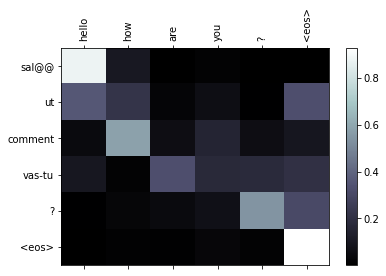

In [58]:
results = translate(transformer_model, 'hello how are you ?', return_output=True)

In [59]:
show_head_view(results)

<IPython.core.display.Javascript object>

In [60]:
show_model_view(results)

<IPython.core.display.Javascript object>

Tokenized source: she 's five years older than me .
Prediction: elle est cinq ans plus vieux que moi .
Detokenized prediction: elle est cinq ans plus vieux que moi .
Google Translate (en->fr): elle a cinq ans de plus que moi .
Google Translate on prediction (fr->en): she is five years older than me.


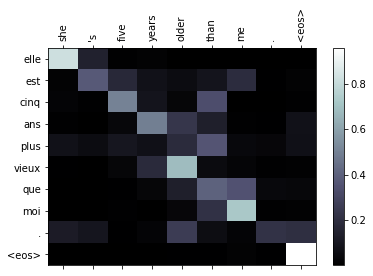

In [61]:
translate(transformer_model, "she 's five years older than me .")

Tokenized source: i know that the last thing you want to do is help me .
Prediction: je sais que la dernière chose que tu veux faire est d' aide .
Detokenized prediction: je sais que la dernière chose que tu veux faire est d' aide .
Google Translate (en->fr): Je sais que la dernière chose que tu veux faire est de m'aider.
Google Translate on prediction (fr->en): I know the last thing you want to do is help.


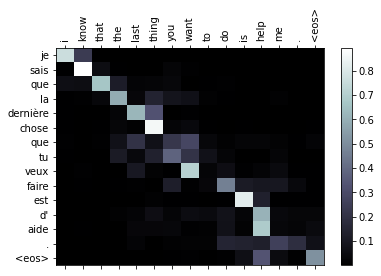

In [62]:
translate(transformer_model, 'i know that the last thing you want to do is help me .')

# Politeness control

Some aspects of generation can be controlled thanks to special tokens in the input.
For instance, this work https://aclanthology.org/N16-1005/ used special tokens to control the politeness of the output.

We will implement this approach for English-French translation, to control the use of "tu" VS "vous" pronouns, which are formal/informal translations of "you".

We only need to partition the training data into formal VS informal splits, by looking for occurrences of "tu" and "vous" (and other pronouns). Then, add source-side control tags depending on the politeness level of the target, and train the model with this.
At test time, we only need to put the right control tag and the model will know how to interpret it to pick the right level of politeness.


## Preparing Dataset

As we only rely on the "politeness control token," it is necessary to prepare distinctive polite and non-polite training samples from the corpus.

While a lot of different aspects of French grammar can be considered here, to start with, we pick sentences that contain "tu" and "vous" — both meaning "you"  in English — and label them as "non-polite" and "polite," respectively.

### Regular expression (regex)

A regular expression is a handy tool for preprocessing sentences by pattern-matching character combinations in strings.

To extract the sentences that contain the word "tu" or "vous" (and some others), we can use the following regexes:
```python
r'(^|\W)(vous|votre|vos|vôtre|vôtres)(\W|$)'
r'(^|\W)(tu|ton|ta|tes|tien|tienne|tiens|tiennes)(\W|$)'
```
They match sentences that contain the corresponding words by making sure that each word is preceded and followed by a "non-word" character.

For more information on regexes, you can checkout the following resources:
- https://www.regular-expressions.info/tutorial.html
- https://regex101.com/#python

In [ ]:
def is_formal(line):
    """
    Contains formal translations of "you/your/yours"
    """
    return bool(re.search(
        r'(^|\W)(vous|votre|vos|vôtre|vôtres)(\W|$)',
        line, re.IGNORECASE))

def is_informal(line):
    """
    Contains informal translations of "you/your/yours"
    """
    return bool(re.search(
        r'(^|\W)(tu|ton|ta|tes|tien|tienne|tiens|tiennes)(\W|$)',
        line, re.IGNORECASE))

### Adding politeness control tags

When we identify sentences that are either polite or non-polite, we can attach corresponding control tags in front of each sentence.

In [ ]:
def preprocess_formal(source_line, target_line=None, source_lang=None, target_lang=None):
    source_line, target_line = preprocess(source_line, target_line)
    source_line = f'<formal> {source_line}'
    return source_line, target_line

def preprocess_informal(source_line, target_line=None, source_lang=None, target_lang=None):
    source_line, target_line = preprocess(source_line, target_line)
    source_line = f'<informal> {source_line}'
    return source_line, target_line

def preprocess_formal_or_informal(source_line, target_line, source_lang=None, target_lang=None):
    """
    Preprocessing function for politeness control:
    - keep only line pairs whose target side has French formal or informal pronouns
    - prepend politeness control tags to the source side
    """
    if is_formal(target_line):
        return preprocess_formal(source_line, target_line)
    elif is_informal(target_line):
        return preprocess_informal(source_line, target_line)
    else:  # this line pair in neither formal nor informal
        # This example will be filtered out by load_dataset (uncomment below to keep it, without a control tag):
        # return preprocess(source_line, target_line)
        return None

### Filtering and loading the dataset

Finally, we can filter and load the dataset by passing these functions to `load_dataset` method.
This will keep only the line pairs where `is_formal(*pair)` is `True` and so on.

In [ ]:
# Use the same dataset as before
train_path = os.path.join(data_dir, 'train.en-fr')
valid_path = os.path.join(data_dir, 'valid.en-fr')

# But preprocess it to keep only line pairs that use tu/vous pronouns and to append control tags
train_data = load_dataset(
    train_path, 'en', 'fr',
    preprocess=preprocess_formal_or_informal,
)

valid_data = load_dataset(
    valid_path, 'en', 'fr',
    preprocess=preprocess_formal_or_informal,
)

## Setting up for training

As we are introducing new vocabularies (i.e., the control tokens), we need to add them to our pretrained model's existing vocabulary.

Here, we replace the last two most infrequent tokens so that we do not need to resize the vocabulary and embeddings.

Note that the replaced words will now be mapped to UNK.

In [ ]:
source_dict = transformer_model.source_dict

# Replace some infrequent tokens with the new control tokens (these words will now be mapped to UNK)
# This is a bit dirty, but this way we don't have to resize the pretrained model's vocabulary and embeddings
source_dict[len(source_dict) - 2] = '<formal>'
source_dict[len(source_dict) - 1] = '<informal>'

# Binarize the training and validation data with these vocabularies
binarize(train_data, source_dict, target_dict, sort=True)
binarize(valid_data, source_dict, target_dict, sort=False)

# You can see that the training source examples now start with special tokens.
print(train_data[:5])

print('train_size={}, valid_size={}, min_len={}, max_len={}, avg_len={:.1f}'.format(
    len(train_data),
    len(valid_data),
    train_data['source_len'].min(),
    train_data['source_len'].max(),
    train_data['source_len'].mean(),
))

reset_seed()

train_iterator = BatchIterator(train_data, 'en', 'fr', batch_size=512, max_len=30, shuffle=True)
valid_iterator = BatchIterator(valid_data, 'en', 'fr', batch_size=512, max_len=30, shuffle=False)

In [ ]:
# Finetune the EN-FR pretrained Transformer model with the new data
new_checkpoint_path = os.path.join(model_root, 'en-fr', 'polite-transformer.pt')
transformer_model.reset_optimizer()
# Uncomment below to reload the pre-trained model
# transformer_model.load(os.path.join(pretrained_model_dir, 'transformer.pt'), reset_optimizer=True)
train_model(transformer_model, train_iterator, [valid_iterator], new_checkpoint_path, epochs=5)

## Inference

In [ ]:
translate(transformer_model, "would you lend me your bicycle ?", preprocess_formal, 'en', 'fr')

In [ ]:
translate(transformer_model, "would you lend me your bicycle ?", preprocess_informal, 'en', 'fr')

## Your turn!

### Improving the performance
Can you improve the performance of politeness control by including more detailed filtering patterns, reflecting the usage of French grammar?

It is probable that our current regular expressions may be limited and end up filtering false negative sentences.

## Control the gender of the output

One known issue of machine translation models (and other NLP models) is that they tend to exhibit gender biases, caused by the same biases appearing in the training data. For instance, in case of ambiguity, a doctor is more likely to be translated as masculine and a nurse as feminine.

For instance "Dr. Dupont is very skilled" -> "Le Dr. Dupont est très compétent" ("compétent" is masculine, the feminine form is "compétente").

You will now use control tags to control the gender of the translation. Sentences starting with `<feminine>` will be translated with the feminine pronoun "elle" and translations of sentences starting with `<masculine>` will use the masculine pronoun "il".

Unfortunately, we don't have a mainstream gender-neutral pronoun in French (like "they" in English).
An option called "inclusive writing" consists in writing both pronouns (e.g., "il/elle"), but there aren't
many natural occurrences of this in existing NLP datasets yet, so for simplicity we will stick to binary masculine/feminine.

You can mostly mirror the "Politeness control" task and change the regular expressions.

A notable difference with the previous task is that

In [63]:
def is_feminine(line):
    """
    Contains the French feminine pronoun "elle"
    """
    raise NotImplementedError

def is_masculine(line):
    """
    Contains the French masculine pronoun "il"
    """
    raise NotImplementedError

def preprocess_feminine(source_line, target_line, source_lang=None, target_lang=None):
    """
    Preprocessing function for feminine line pairs: the source side will have a special <feminine> token
    """
    raise NotImplementedError

def preprocess_masculine(source_line, target_line, source_lang=None, target_lang=None):
    """
    Preprocessing function for masculine line pairs: the source side will have a special <masculine> token
    """
    raise NotImplementedError

def feminize(line):
    """
    Change the English pronouns in `line` to be feminine
    """
    raise NotImplementedError

def masculinize(line):
    """
    Change the English pronouns in `line` to be masculine
    """
    raise NotImplementedError

def preprocess_masculine_or_feminine(source_line, target_line, source_lang=None, target_lang=None):
    """
    Preprocessing function for gender control:
    - add the <feminine> source tag to sentences pairs whose target side is feminine
    - add the <masculine> source tag to sentences pairs whose target side is masculine
    - do data augmentation to swap the source-side gender with probability 0.5
    """
    if is_feminine(target_line):
        if np.random.rand() < 0.5:
            source_line = masculinize(source_line)
        return preprocess_feminine(source_line, target_line)
    elif is_masculine(target_line):
        if np.random.rand() < 0.5:
            source_line = feminize(source_line)
        return preprocess_masculine(source_line, target_line)
    else:
        # return preprocess(source_line, target_line)
        return None

#### Once the previous functions have been filled in, the following can be run without modifications:

In [ ]:
reset_seed()

train_data = load_dataset(train_path, 'en', 'fr', preprocess=preprocess_masculine_or_feminine)
valid_data = load_dataset(valid_path, 'en', 'fr', preprocess=preprocess_masculine_or_feminine)

source_dict = transformer_model.source_dict

# Replace some infrequent tokens with the new control tokens (these words will now be mapped to UNK)
# This is a bit dirty, but this way we don't have to resize the pretrained model's vocabulary and embeddings
source_dict[len(source_dict) - 2] = '<feminine>'
source_dict[len(source_dict) - 1] = '<masculine>'

# Binarize the training and validation data with these vocabularies
binarize(train_data, source_dict, target_dict, sort=True)
binarize(valid_data, source_dict, target_dict, sort=False)

# You can see that the training source examples now start with special tokens.
print(train_data[:5])

print('train_size={}, valid_size={}, min_len={}, max_len={}, avg_len={:.1f}'.format(
    len(train_data),
    len(valid_data),
    train_data['source_len'].min(),
    train_data['source_len'].max(),
    train_data['source_len'].mean(),
))

train_iterator = BatchIterator(train_data, 'en', 'fr', batch_size=512, max_len=30, shuffle=True)
valid_iterator = BatchIterator(valid_data, 'en', 'fr', batch_size=512, max_len=30, shuffle=False)

In [ ]:
# Finetune the EN-FR pretrained Transformer model with the new data
new_checkpoint_path = os.path.join(model_root, 'en-fr', 'gender-controllable-transformer.pt')
transformer_model.reset_optimizer()
# Uncomment below to reload the pre-trained model:
# transformer_model.load(os.path.join(pretrained_model_dir, 'transformer.pt'), reset_optimizer=True)
train_model(transformer_model, train_iterator, [valid_iterator], new_checkpoint_path, epochs=5)

In [ ]:
translate(transformer_model, "she goes to the ALPS winter school .", preprocess_masculine, 'en', 'fr')

In [ ]:
translate(transformer_model, "she goes to the ALPS winter school .", preprocess_feminine, 'en', 'fr')

# Domain adaptation

Can you think of any other domains where the usage of control tags can be effective?

For example, domain adaption on medical or law fields could be an option.
  - (Medical) https://ufal.mff.cuni.cz/ufal_medical_corpus
  - (Law) https://www.clarin.eu/resource-families/parallel-corpora
  
Note that it is also important to have "non-medical" or "non-law" corpus in the overall training set as well.

# Multilingual Translation

We will now look at multilingual translation, another trendy topic in MT. A single model can be trained to translate from multiple languages into multiple languages (https://aclanthology.org/Q17-1024/, https://arxiv.org/abs/2010.11125).
This is done by having a single multilingual BPE model and dictionary, shared between all languages. The embedding matrix (and other model parameters) are also shared across languages. And this multilingual model is trained on multiple parallel datasets (e.g., en->fr, fr->en, de->en, en->de). Controlling the target language can be achieved by using special tokens, like for politeness control.

Load a pre-trained **de, fr <-> en** model. The multilingual dictionary includes tokens for all three languages plus the language codes (`<lang:de>`, `<lang:en>`, `<lang:fr>`), which are prepended to each source sequence to identify the target language.

In [ ]:
multi_model_dir = os.path.join(root_dir, 'pretrained_models', 'de-en-fr')

multi_dict = data.Dictionary.load(os.path.join(multi_model_dir, 'dict.txt'))

encoder = models.TransformerEncoder(source_dict=multi_dict, hidden_size=512, num_layers=2, heads=4)
decoder = models.TransformerDecoder(
    target_dict=multi_dict,
    hidden_size=512, num_layers=1, heads=4,
    embedding=encoder.embedding)  # tied embeddings (multilingual models usually have shared source/target embeddings)

multi_model = models.EncoderDecoder(encoder, decoder, lr=0.0005, use_cuda=not cpu)

checkpoint_path = os.path.join(multi_model_dir, 'transformer.pt')
multi_model.load(checkpoint_path)

### Multilingual evaluation

Modify the `preprocess` function to automatically prepend language codes to all source sequences (when calling `translate`, or `load_data`).

And load test sets in all language pairs.

In [ ]:
def preprocess_multi(source_line, target_line, source_lang=None, target_lang=None):
    source_line, target_line = preprocess(source_line, target_line)
    source_line = f'<lang:{target_lang}> {source_line}'
    return source_line, target_line

test_sets = OrderedDict()

for pair in 'en-fr', 'fr-en', 'en-de', 'de-en', 'de-fr', 'fr-de':
    src, tgt = pair.split('-')
    path = os.path.join(data_dir, f'test.{src}-{tgt}')
    dataset = load_dataset(path, src, tgt, preprocess_multi)
    binarize(dataset, source_dict=multi_dict, target_dict=multi_dict, sort=False)
    iterator = BatchIterator(dataset, src, tgt, batch_size=512, max_len=30, shuffle=False)
    test_sets[pair] = iterator
    
en_centric_test_sets = list(test_sets.values())[:4]
non_en_centric_test_sets = list(test_sets.values())[4:]

In [ ]:
chrf = evaluate_model(multi_model, *en_centric_test_sets)

### Interact with the model

In [ ]:
# translate accepts preprocess, source_lang and target_lang arguments
translate(multi_model, "she 's five years older than me .", preprocess_multi, 'en', 'fr')

In [ ]:
translate(multi_model, 'sie ist fünf jahre älter als ich .', preprocess_multi, 'de', 'en')

### Zero-shot translation

In theory, the model can do **zero-shot** translation, i.e., translate between German and French even though it has never seen German-French sentence pairs during training.

In [ ]:
chrf = evaluate_model(multi_model, *non_en_centric_test_sets)

#### However, in practice zero-shot performance is very bad. Interact with the model to understand why.

In [ ]:
translate(multi_model, 'sie ist fünf jahre älter als ich .', preprocess_multi, 'de', 'fr')

In [ ]:
translate(multi_model, 'elle a cinq ans de plus que moi .', preprocess_multi, 'fr', 'de')

## Your Turn!

Choose one of these exercises, or both!

### Hyper-parameter tuning

Find the best hyper-parameters for Transformer **en-fr**. Share your best test chrF scores on Slack!

*Don't forget to reload the `preprocess` function at the start of the notebook*

- Hyper-parameters: `lr`, `batch_size`, `num_layers`, `hidden_size`, `dropout`, `heads`, etc.
- Other improvements: modify the learning rate scheduler and optimizer in `models.EncoderDecoder`; use different embedding size and hidden size, etc.

### Multilingual NMT

Train your own multilingual NMT model.

Tips:
- Create a multilingual dictionary by concatenating the tokenized data in all languages. Or simply re-use the dictionary of the pre-trained model (`multi_dict`).
- Use the same dictionary for the source and target sides, and share the embeddings between your encoder and decoder (do: `decoder.embedding = encoder.embedding`).
- Use `data.MultiBatchIterator(iterator_list)` to concatenate a list of training iterators (one for each language pair) into a single iterator, which is compatible with `train_model`.
- `train_model` can take a list of several validation iterators, which will let you validate your model on several language pairs.
- Improve your model's performance on **de-fr** and **fr-de** by including training data for these languages pairs (`data/train.de-fr.de` and `data/train.de-fr.fr`).

### Train bilingual or multilingual models on other language pairs

- Modify and re-run `./download-data.sh` to download data in new languages, preprocess this data and train BPE models

# Adaptation to a new language pair

Large-scale multilingual MT models are great as they can provide translations for multiple language pairs with just a single model.

However, these models tend to be very large in model parameters and require heavy computational power to train.

Therefore, when adding a new language pair, instead of re-training the model using the existing and newly added corpora from scratch, it would be more efficient to finetune the pretrained model only using the new dataset.

## Naive finetuning of the model
In the above "Multilingual Translation" section, we observed poor zero-shot MT performance for the "DE, FR <-> EN" model.

We saw that, while it is possible to do "DE <-> FR" translation, as the model has never seen such bilingual data, the performance was rather poor.

Suppose now we want to explicitly train the model to additionally support the "DE -> FR" translation.
One way is to load the corresponding dataset and finetune the pretrained model.

In [ ]:
# Load DE-FR training data
src, tgt = 'de', 'fr'

train_path = os.path.join(data_dir, f'train.{src}-{tgt}')
valid_path = os.path.join(data_dir, f'valid.{src}-{tgt}')

# set max_size to 10000 for fast debugging
train_data = load_dataset(train_path, src, tgt, preprocess_multi, max_size=None)
valid_data = load_dataset(valid_path, src, tgt, preprocess_multi)

binarize(train_data, source_dict=multi_dict, target_dict=multi_dict, sort=True)
binarize(valid_data, source_dict=multi_dict, target_dict=multi_dict, sort=False)

reset_seed()

train_iterator = BatchIterator(train_data, src, tgt, batch_size=512, max_len=30, shuffle=True)
valid_iterator = BatchIterator(valid_data, src, tgt, batch_size=512, max_len=30, shuffle=False)

In [ ]:
# Finetune the entire model on EN-FR
new_checkpoint_path = os.path.join(model_root, 'de-en-fr', 'finetuned-transformer.pt')
train_model(multi_model, train_iterator, [valid_iterator], new_checkpoint_path, epochs=1)

## Catastrophic forgetting
After the finetuning, we evaluate the model on FR-EN and DE-FR test sets.

Unfortunately, this finetuning resulted in a drop in performance for the FR-EN translation.

This phenomenon of model forgetting previously learned information upon learning new information is called "catastrophic forgetting".

In [ ]:
# Now evaluate on FR-EN and DE-FR test sets. We see a drop in FR-EN performance (catastrophic forgetting)
chrf = evaluate_model(multi_model, test_sets['fr-en'], test_sets['de-fr'])

## Adapter modules
An alternative to finetuning and an effective way of bypassing the problem of catastrophic forgetting is the usage of adapter modules [Houlsby, Neil, et al. "Parameter-efficient transfer learning for NLP." International Conference on Machine Learning. PMLR, 2019].

An adapter module is often a small bottle-neck architecture, consisting of a few feedforward networks and a skip-connection, inserted twice in each Transformer layer.

The insertion of adapter modules incurs additional model parameters, but they are often kept small compared to the size of the original network.

During the adapter tuning, only the adapter modules are trained with the downstream data — in our case, the DE-FR data — while the rest of the model parameters are fixed.

In [ ]:
from models import AdapterTransformerDecoder, AdapterTransformerEncoderLayer

class AdapterLayer(nn.Module):
    # This class definition is just for show. Adapter layers are actually defined in models.py
    # Same adapter architecture as in this paper: https://arxiv.org/abs/1909.08478
    def __init__(self, input_dim, projection_dim):
        """
        input_dim: Transformer model's hidden size
        projection_dim: bottleneck dimension of the adapter (usually smaller than input_dim), can be tuned
        to control the amount of new parameters.
        """
        super().__init__()
        self.down = nn.Linear(input_dim, projection_dim)
        self.up = nn.Linear(projection_dim, input_dim)
        self.layer_norm = nn.LayerNorm(input_dim)
        # initialize the adapter weights to small values, so that it computes the identity function
        # (or close enough) at the beginning of training (i.e., it keeps the Transformer layer outputs mostly
        # unchanged)
        nn.init.uniform_(self.down.weight, -1e-6, 1e-6)
        nn.init.uniform_(self.up.weight, -1e-6, 1e-6)
        nn.init.zeros_(self.down.bias)
        nn.init.zeros_(self.up.bias)

    def forward(self, x):
        y = self.layer_norm(x)
        # down projection to a bottleneck dimension
        y = self.down(y)
        # non-linearity
        y = F.relu(y)
        # up projection to the model's dimension
        y = self.up(y)
        # residual connection
        return x + y

class AdapterTransformerEncoder(models.TransformerEncoder):
    def __init__(self, adapter_ids, projection_dim, *args, **kwargs):
        """
        Create a Transformer Encoder with adapter layers (that will be plugged in after each Transformer layer)
        adapter_ids: list of adapter names (e.g., ['de-fr', 'fr-de']), one set of adapters will be created for each
        of those. Adapters can be activated/deactivated thanks to the "select_adapters" function.
        projection_dim: bottleneck dimension of the adapters
        """
        self.adapter_ids = adapter_ids
        self.projection_dim = projection_dim
        super().__init__(*args, **kwargs)
        for name, param in self.named_parameters():
            if '.adapters.' not in name:
                param.requires_grad = False

    def select_adapter(self, id):
        # Use this method to activate a specific set of adapters (e.g., 'de-fr')
        # Set id=None to deactivate adapters (and use the initial Transformer model)
        for layer in self.layers:
            layer.adapter_id = id

    def build_layer(self, layer_id):
        # This method can be modified to add adapters only at some layers (e.g., first encoder layer)
        # Use models.TransformerEncoderLayer instead for standard Trandformer layers
        return AdapterTransformerEncoderLayer(
            self.adapter_ids,
            self.projection_dim,
            self.hidden_size,
            self.heads,
            self.dropout
        )

In [ ]:
encoder = AdapterTransformerEncoder(
    source_dict=multi_dict,
    adapter_ids=['de-fr'],   # you can create adapters for more than one language pair
    projection_dim=64,       # bottleneck dimension of the adapters
    hidden_size=512,
    num_layers=2,
    heads=4,
)
decoder = AdapterTransformerDecoder(
    target_dict=multi_dict,
    adapter_ids=['de-fr'],
    projection_dim=64,
    hidden_size=512,
    num_layers=1,
    heads=4,
    embedding=encoder.embedding,
)

adapter_model = models.EncoderDecoder(encoder, decoder, lr=0.0005, use_cuda=not cpu)

pretrained_checkpoint_path = os.path.join(multi_model_dir, 'transformer.pt')
# Load the pre-trained model's parameters, set strict to False for partial initialization without errors.
# As the pre-trained checkpoint does not contain parameters for the adapter layers, those are initialized at random.
# We also reset the optimizer because its parameters to not match anymore and the learning rate might be too small.
adapter_model.load(pretrained_checkpoint_path, strict=False, reset_optimizer=True)

new_checkpoint_path = os.path.join(model_root, 'de-en-fr', 'adapter-transformer.pt')

# Show the number of trained parameters.
# All Transformer parameters are frozen except the adapter parameters.
total_params = 0
trained_params = 0
for name, param in adapter_model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trained_params += param.numel()
print(f'Total parameters: {total_params}, trained parameters: {trained_params}')

In [ ]:
# Activate the DE-FR adapters and train them on the DE-FR data (the other parameters are frozen)
# Note that you can do encoder.select_adapter(None) to train only decoder adapters
encoder.select_adapter('de-fr')
decoder.select_adapter('de-fr')
train_model(adapter_model, train_iterator, [valid_iterator], new_checkpoint_path, epochs=1)

## Turning on adapters for evaluation

After the adapter tuning, we can turn on the "DE-FR" adapters to do inference.

We can see that with just 200K new parameters (1.4% of the initial model's size) we can adapt to the DE-FR direction without hurting performance of the other language pairs.

In [ ]:
# Activate the DE-FR adapters to translate in the DE-FR direction
encoder.select_adapter('de-fr')
decoder.select_adapter('de-fr')
chrf = evaluate_model(adapter_model, test_sets['fr-en'], test_sets['de-fr'])

In [ ]:
# Deactivate the adapters to use the initial model (e.g., to translate in the English-centric directions).
encoder.select_adapter(None)
decoder.select_adapter(None)
chrf = evaluate_model(adapter_model, test_sets['fr-en'], test_sets['de-fr'])

## Your turn!

- Can you introduce more adapters to support more language pairs?
- Do you think adapters can also be used in the task of domain adaptation as well?

# Check out the other topics in MT!
There are also many other interesting and important research topics in MT which are not covered in this lab session.

Here are some of them:
- **Unsupervised or low-resource MT**
  - How can we leverage monolingual data when bilingual data is not available or extremely scarce?
  - How can we improve the performance of low-resourced language pairs?
- **Document-level context-aware MT**
  - How can we effectively translate a text containing multiple sentences while keeping the translation coherent and faithful?
- **Domain-adapted or personalized MT, Continual learning for MT**
  - How can we extend an existing model for new domains, language pairs, or simply new addition of data?
- **Efficient MT**
  - How can we train and serve MT models more efficiently? Efficiency here can mean both space and time efficiency.
  
If you are interested in finding out more about MT, you can check out the [WMT conference](https://www.statmt.org/wmt21/) that is held annually.